In [46]:
#!/usr/bin/python3.10
# coding=utf-8
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily
import sklearn.cluster
import numpy as np
import os
# muzete pridat vlastni knihovny



In [47]:
def make_geo(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    """ Make a GeoDataFrame from a DataFrame with coordinates and date columns.

    Args:
        df (pd.DataFrame): dataframe 

    Returns:
        geopandas.GeoDataFrame: geodataframe
    """

    # remove nan and inf values
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["d", "e"], how="all")
    
    # Make a date column
    df["date"] = pd.to_datetime(df["p2a"], cache=True)
    
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['d'], df['e']), crs="EPSG:5514")





In [48]:

def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None, show_figure: bool = False):
    """ Plot a GeoDataFrame with contextily basemap.

    Args:
        gdf (geopandas.GeoDataFrame): geodataframe
        fig_location (str, optional): location to save figure. Defaults to None.
        show_figure (bool, optional): show figure. Defaults to False.
    """

    region = "JHM"

    data = gdf[(gdf["region"] == region) & (gdf["p11"] >= 3) & gdf["date"].dt.year.isin([2018, 2019, 2020, 2021])].set_geometry(gdf.centroid).to_crs("EPSG:3857")

    # get graph bounds
    bounds = data.total_bounds
    fig, axs = plt.subplots(2,2, figsize=(10, 10))
    i = 0
    for r in range(2):
        for c in range(2):
            axs[r, c].set_title(region + " kraj ({})".format(2018 + i))
            axs[r, c].axis("off")
            # axs[r, c].set_xlim(xmin=1750000.0, xmax=bounds[2])
            # axs[r, c].set_ylim(ymin=bounds[1], ymax=bounds[3])

            data[(data["date"].dt.year == (2018 + i))].centroid.plot(ax=axs[r, c], markersize=1, color="red")
            contextily.add_basemap(axs[r, c], crs=data.crs.to_string(), source=contextily.providers.Stamen.TonerLite)
            i += 1
    
    plt.tight_layout()

In [49]:
def plot_cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None,
                 show_figure: bool = False):
    
    """ Plot a GeoDataFrame with contextily basemap and clustered points.

    Args:
        gdf (geopandas.GeoDataFrame): geodataframe
        fig_location (str, optional): location to save figure. Defaults to None.
        show_figure (bool, optional): show figure. Defaults to False.
    """

    chosen_region = "JHM"
    title_str = f"Nehody v {chosen_region} kraji na silnicích 1., 2. a 3. třídy"

    # Subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # filter region, roadtype and transform to webmercator
    data = gdf[(gdf["region"] == chosen_region) & gdf["p36"].isin([1, 2, 3])].set_geometry(gdf.centroid).to_crs("EPSG:3857")
    gdf = gdf.set_geometry(gdf.centroid).to_crs("EPSG:3857")

    # collect points in a 2d array
    points = np.reshape(list(zip(data.geometry.x, data.geometry.y)), (-1, 2))

    # cluster points
    data["frequency_group"] = sklearn.cluster.MiniBatchKMeans(n_clusters=20).fit(points).labels_    

    data = data.dissolve(by="frequency_group", aggfunc={"region": "count"})

    data.plot(ax=ax, markersize=2, column="region", legend=True, alpha=0.5, legend_kwds={"orientation": "horizontal", "label": "Počet nehod v úseku"})
    ax.set_axis_off()
    contextily.add_basemap(ax, crs=data.crs.to_string(), alpha=0.9,
                    reset_extent=False, source=contextily.providers.Stamen.TonerLite)
    ax.set_title(title_str, fontsize="small")
    plt.tight_layout()

    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()

    # contextily.add_basemap(ax, crs="epsg:3857", source=contextily.providers.Stamen.TonerLite, zoom=10, alpha=0.6)  ###

In [50]:
gdf = make_geo(pd.read_pickle("accidents.pkl.gz"))
# print number of rows
print(gdf.shape[0])
#print column names
print(gdf.columns)
# print all unique values in column p36
print(gdf["p36"].unique())

571225
Index(['p1', 'p36', 'p37', 'p2a', 'weekday(p2a)', 'p2b', 'p6', 'p7', 'p8',
       'p9', 'p10', 'p11', 'p12', 'p13a', 'p13b', 'p13c', 'p14', 'p15', 'p16',
       'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p27', 'p28',
       'p34', 'p35', 'p39', 'p44', 'p45a', 'p47', 'p48a', 'p49', 'p50a',
       'p50b', 'p51', 'p52', 'p53', 'p55a', 'p57', 'p58', 'a', 'b', 'd', 'e',
       'f', 'g', 'h', 'i', 'j', 'k', 'l', 'n', 'o', 'p', 'q', 'r', 's', 't',
       'p5a', 'region', 'date', 'geometry'],
      dtype='object')
[4 5 6 8 7 1 0 3 2]


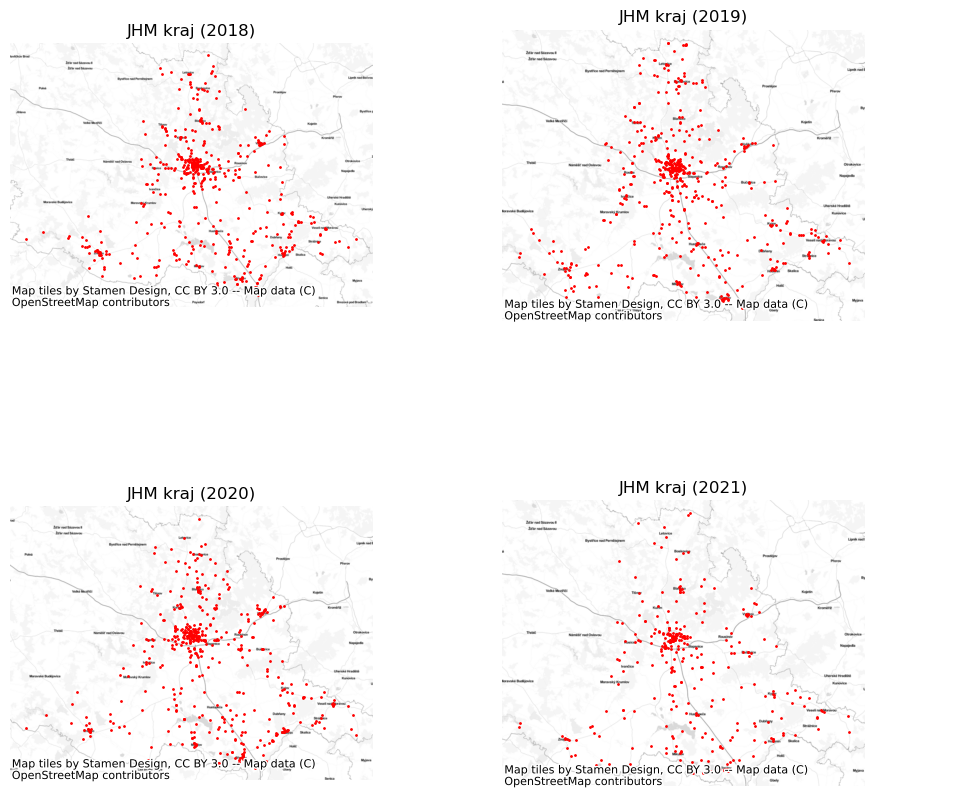

In [51]:
plot_geo(gdf, "geo1.png", True)


/home/tomas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


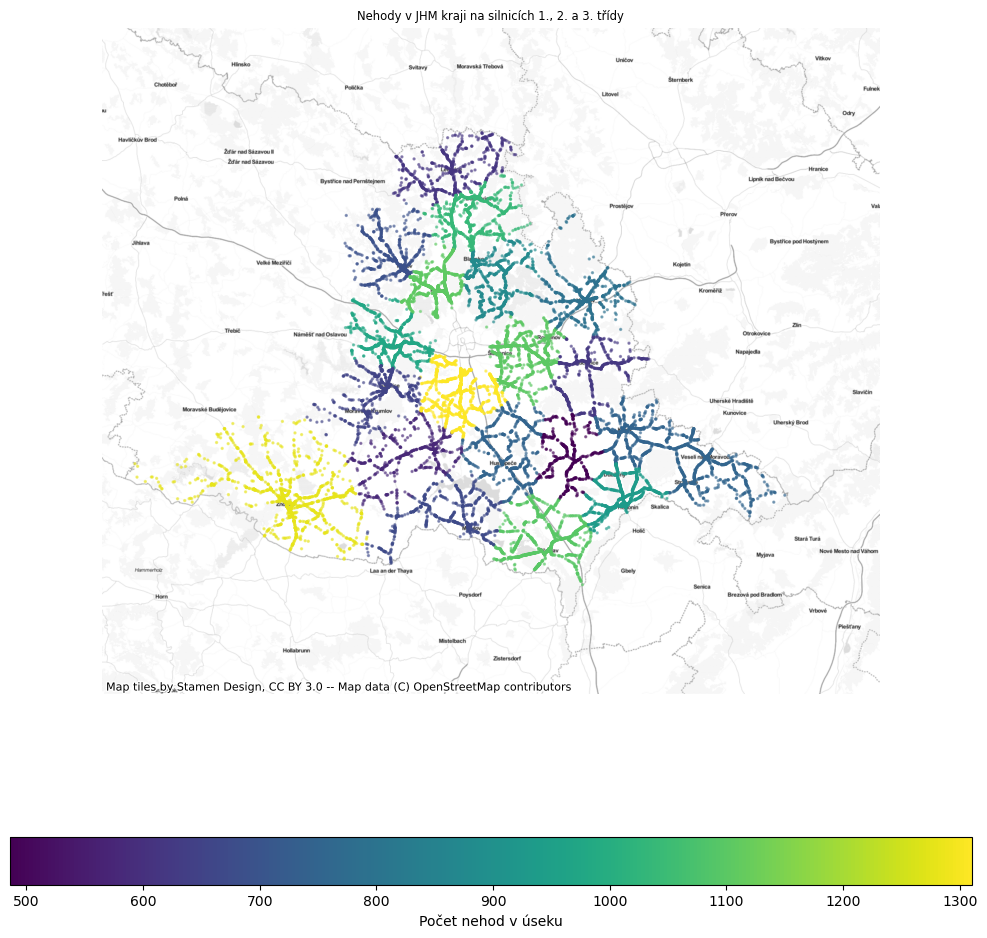

In [52]:
plot_cluster(gdf, None, True)

In [53]:
def cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None,
                 show_figure: bool = False):
    """ Vykresleni grafu s lokalitou vsech nehod v kraji shlukovanych do clusteru """
   # Static things
    chosen_region = "JHM"
    title_str = f"Nehody v {chosen_region} kraji na cestách 1. triedy"

    # Subplots
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # filter region, roadtype and transform to webmercator
    data = gdf[(gdf["region"] == chosen_region) & gdf["p36"].isin([1, 2, 3])].to_crs("EPSG:3857")

    # collect points in a 2d array
    points = np.reshape(list(zip(data.geometry.x, data.geometry.y)), (-1, 2))

    # cluster into frequency groups
    # Agglomerative clustering was chosen because of many clusters and connectivity constraints
    # The results after agglomerative clustering also resemble the given example map the most
    # and this clustering method produces similar results in each run unlike e.g. MiniBatch KMeans
    data["frequency_group"] = sklearn.cluster.MiniBatchKMeans(n_clusters=10).fit(points)

    # magic at this point.. for each group of points assign the cluster size
    # this value will represent the color in the resulting map
    # create cluster with size 0 to color clusters properly
    # data["p1"] = 0
    # data["p1"] = data["p1"] - data["p1"].min()
    data = data.dissolve(by="frequency_group", aggfunc={"p1": "count"})

    # mapping of cluster size to color



    data.plot(ax=ax, markersize=1, column="p1", legend=True, legend_kwds={"orientation": "horizontal", "label": "Počet nehod v úseku"})
    ax.set_axis_off()
    contextily.add_basemap(ax, crs=data.crs.to_string(), alpha=0.9, attribution_size=6,
                    reset_extent=False, source=contextily.providers.Stamen.TonerLite)
    ax.set_title(title_str, fontsize="small")
    plt.tight_layout()

    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()


/home/tomas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


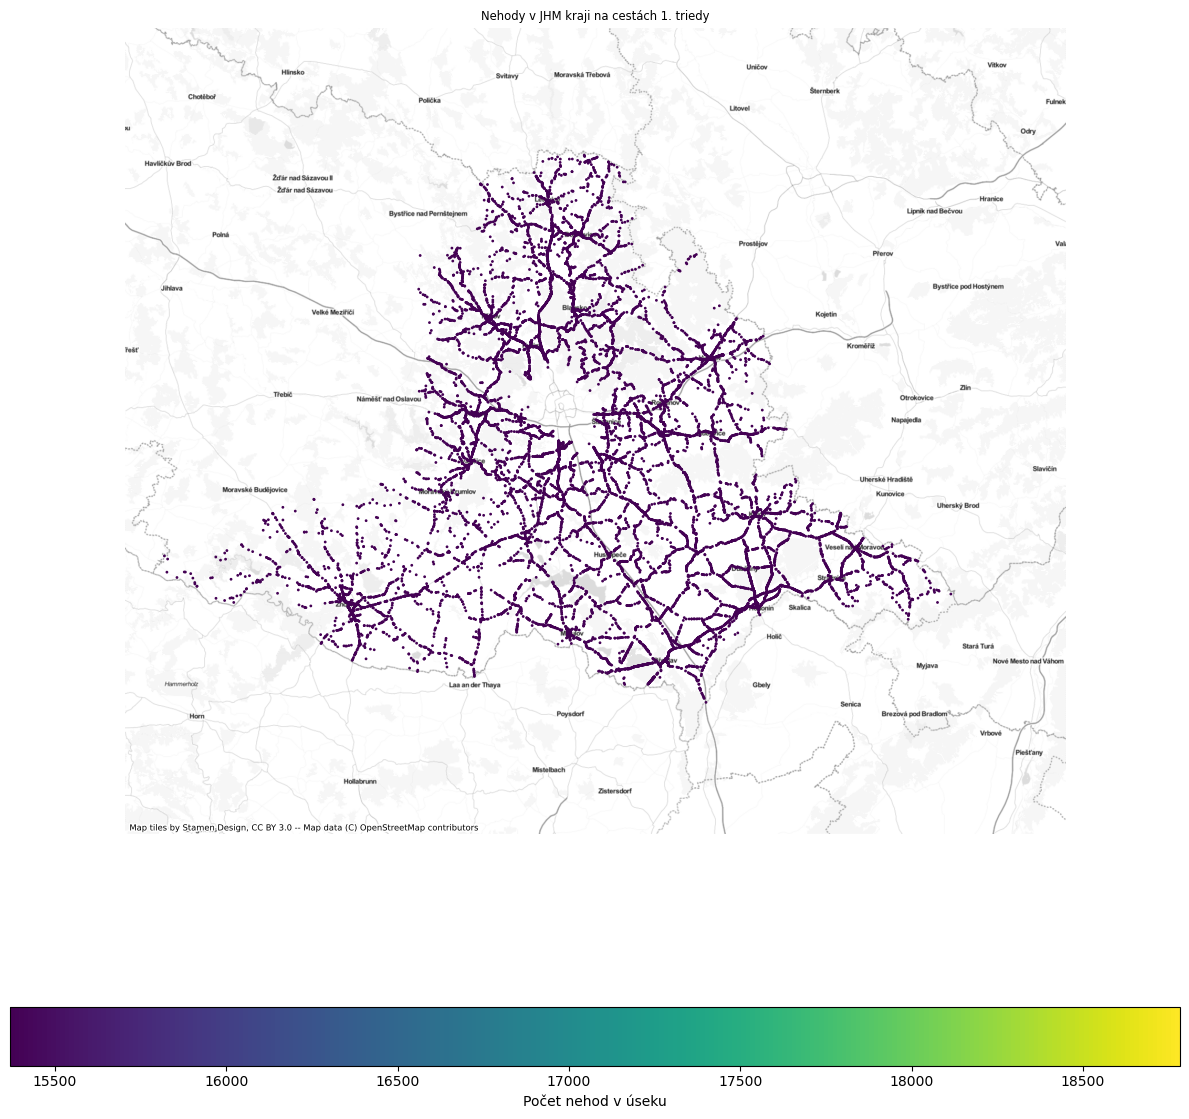

In [54]:
cluster(gdf, None, True)

In [55]:

def make_geo(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    """ Konvertovani dataframe do geopandas.GeoDataFrame se spravnym kodovani"""
    pass

def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None,
             show_figure: bool = False):
    """ Vykresleni grafu s nehodami s alkoholem pro roky 2018-2021 """
    pass

def plot_cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None,
                 show_figure: bool = False):
    """ Vykresleni grafu s lokalitou vsech nehod v kraji shlukovanych do clusteru """
    pass

if __name__ == "__main__":
    # zde muzete delat libovolne modifikace
    gdf = make_geo(pd.read_pickle("accidents.pkl.gz"))
    plot_geo(gdf, "geo1.png", True)
    plot_cluster(gdf, "geo2.png", True)
